# Měření BMI pomocí hloubkového senzoru
Tento úkol je zaměřen na využití dat z hloubkového senzoru - konkrétně ze senzoru **Microsoft Kinect**. Kinect je starší druh hloubkového senzoru, který umožňuje získávat hloubkové mapy v rozlišení až 640 × 480 pixelů. V každém pixelu je uložena hodnota vzdálenosti od senzoru v jednotkách mm. 

![](images/kinect_view.png)

Firmware uvnitř senzoru dále umožňuje automaticky detekovat osoby a aproximovat je tzv. skeletonem. **Skeleton** je objekt, který je definován ve své jednodušší variantě 20 body těla. K automatické detekci osoby a vytvoření skeletonu je zapotřebí kalibraovat senzor pomocí utvoření tzv. "[**psi pózy**](https://www.google.cz/search?biw=1848&bih=978&tbm=isch&sa=1&ei=WO8DXIedG6iMrwT7qry4AQ&q=psi+pose&oq=psi+pose&gs_l=img.3...0.0..8771...0.0..0.0.0.......1......gws-wiz-img.Ak1KqQmBEao)" (podle řečkého písmene &Psi;). Body jsou vidět na následujícím obrázku.

![](images/kinect_joint_points.png)

## Citace
[1] VELARDO, Carmelo a Jean-Luc DUGELAY. Weight estimation from visual body appearance. In: *2010 Fourth IEEE International Conference on Biometrics: Theory, Applications and Systems (BTAS)* [online]. IEEE, 2010, 2010, s. 1-6 [cit. 2018-12-02]. DOI: 10.1109/BTAS.2010.5634540. ISBN 978-1-4244-7581-0. Dostupné z: http://ieeexplore.ieee.org/document/5634540/ 

[2] PROKOPENKO, Stan. Human Figure Proportions - Average Figures - Dr. Paul Richer. *Proko - How to Draw*. [online]. 18.11.2013 [cit. 2015-05-10]. Dostupné z: http://www.proko.com/human-figure-proportions-average-richer/

### Import knihoven a konfigurace

In [7]:
from improutils import *
import json
import numpy as np
import cv2
from pprint import pprint
from math import pi
import itertools
import matplotlib.pyplot as plt

# spustí pomocné funkce z vedlejšího notebooku
%run help_functions.py

<a id='premium'>Prémiová funkce</a>

In [244]:
 def measure_distances_using_impro(image, contour, specified_points, measured_joints_pairs):
    '''
    Měří vzdálenosti mezi specifikovanými body na kontuře těla v daném obrázku
    
    Parametry:
    ----------
    image : numpy.ndarray
        Obrázek, na kterém se provádí měření
    contour : list of numpy.ndarray
        Kontura těla extrahovaná z obrázku
    specified_points : list of tuples
        Seznam specifických bodů na kontuře, kde budou měřeny vzdálenosti
    measured_joints_pairs : list of tuples
        Seznam párů bodů, mezi kterými se budou vzdálenosti měřit

    Návratová hodnota:
    ------------------
    tuple
        Čtyři naměřené vzdálenosti mezi specifikovanými body
    '''
    # Lengts of line segments to draw
    # ... it's highly sensitive to the size of body part
    dxs = [12, 12, 15, 40]
    
    # Vytvoření prázdného obrázku stejné velikosti jako původní obrázek
    just_contour = np.zeros_like(image)

    # Vykreslení kontury těla na prázdný obrázek
    just_contour = draw_contour(just_contour, contour)

    # Vytvoření kopie kontury, na kterou budou později přidány normály
    conts_with_norm_lines = np.copy(just_contour)
    
    # Iterace přes každý specifikovaný bod a jeho odpovídající pár "kloubů"
    dists = []
    for i, point in enumerate(specified_points):
        p1 = measured_joints_pairs[i][0]
        p2 = measured_joints_pairs[i][1]
        
        # Vytvoření prázdného obrázku pro vykreslení normály
        norm_lines = np.zeros_like(just_contour)

        # Vykreslení kolmé úsečky k segmentu mezi body p1 a p2 v daném bodě s délkou dxs[i]
        norm_lines = draw_norm_line_segment_in_point(p1, p2, point, dxs[i], norm_lines) ###

        # Pomocí bitového OR sloučíme původní konturu s nově vykreslenou normálou
        conts_with_norm_lines = cv2.bitwise_or(conts_with_norm_lines, norm_lines)

        # Pomocí bitového AND identifikujeme oblasti, kde se překrývá kontura a normální čára
        im = cv2.bitwise_and(just_contour, norm_lines)

        # Získání souřadnic ne-nulových pixelů, kde došlo k překryvu
        idx = np.transpose(np.nonzero(im.T))

        # Iteruje přes všechny překryvné body a vypočítává vzdálenost mezi každým párem sousedních bodů
        for j in range(0, len(idx)-1):
            dist = distance_cm(idx[j], idx[j+1], k)

            # Uložíme a označíme vzdálenost jen, pokud je větší než dvojnásobek konstanty k, aby se odstranily malé falešné měření
            if dist > 2 * k:
                dists.append(dist)

                # Zakreslení kruhů na příslušných bodech pro vizualizaci - ohraničují hranici kontury těla
                cv2.circle(conts_with_norm_lines, tuple(idx[j].T), 3, 80, -1)
                cv2.circle(conts_with_norm_lines, tuple(idx[j+1].T), 3, 80, -1)
                break

    plt.imshow(conts_with_norm_lines, cmap="gray")
    assert len(dists) == 4, 'You don\'t have enough points for measure distances. You probably chose RIGHT arm, hand, etc. Try choosing left ones.'

    # Vizualizace výsledného obrázku s konturami a normálami
    plt.imshow(conts_with_norm_lines, cmap="gray")

    # Návrat čtyř naměřených vzdáleností jako n-tice
    return dists[0], dists[1], dists[2], dists[3]

Goniometrická interpretace

### Použitelné funkce
Seznamte se a na příslušném místě použijte!

In [228]:
def distance_cm(p1, p2, k):
    '''Distance between two points multiplied by k'''
    return np.linalg.norm(np.array(p1) - np.array(p2)) * k

def point_in_distance(p1, p2, frac):
    '''Creates point in specific distance (fraction) between two points'''
    assert type(p1) is type(tuple()), 'Bod p1 není TUPLE!'
    assert type(p2) is type(tuple()), 'Bod p2 není TUPLE!'
    
    # Get the top point.
    if p1[1] < p2[1]:
        top = p1
        bottom = p2
    else:
        top = p2
        bottom = p1

    # Get the vector from the top to the bottom point.
    dx = bottom[0] - top[0]
    dy = bottom[1] - top[1]

    # Add the vector multiplied by the fraction to get the desired point.
    p_new_x = top[0] + (dx * frac)
    p_new_y = top[1] + (dy * frac)

    # Return result
    return (p_new_x, p_new_y)

def recount_joints(meta, crop_tl):
    '''Recounts joints coordinates if you crop the default image and returns new meta dict.'''
    meta_new = dict()
    for key in meta.keys():
        x = meta[key][0] - crop_tl[0]
        y = meta[key][1] - crop_tl[1]
        meta_new[key] = [x, y]
    
    return meta_new

---

## Úkol

K výpočtu [body mass indexu (BMI)](https://cs.wikipedia.org/wiki/Index_t%C4%9Blesn%C3%A9_hmotnosti) jsou k dispozici nasnímaná data hloubkové mapy a metadata. Výpočet pro odhad hmotnosti vychází z publikace [1]. 

Za úkol je možné získat až **7 bodů** a až **2 prémiové**.

---

K výpočtu BMI bude zapotřebí změřit celkem 7 údajů. Údaje jsou přehledně zobrazeny v <a id='tab'>tabulce</a> na následujícím obrázku [1]. 

![](images/body_measurements.png)

#### 1) Načtěte data
Načtěte data hloubkové mapy ve formátu `uint16` a k tomu metadata ve formátu `json`. Metadata obsahují souřadnice bodů pro všech 20 bodů skeletonu z hloubkové mapy a převodní konstantu `k` pro přepočet vzdáleností z pixelů na cm. Uložte si konstantu zvlášť a souřadnice bodů také.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

In [229]:
import builtins

0.53588
{'ankle_left': [414, 349],
 'ankle_right': [352, 349],
 'elbow_left': [431, 173],
 'elbow_right': [325, 170],
 'foot_left': [414, 360],
 'foot_right': [351, 359],
 'hand_left': [467, 218],
 'hand_right': [286, 213],
 'head': [379, 77],
 'hip_center': [377, 188],
 'hip_left': [391, 201],
 'hip_right': [364, 201],
 'k': 0.53588,
 'knee_left': [404, 285],
 'knee_right': [358, 285],
 'shoulder_center': [376, 109],
 'shoulder_left': [407, 129],
 'shoulder_right': [350, 127],
 'spine': [378, 177],
 'wrist_left': [459, 207],
 'wrist_right': [294, 202]}


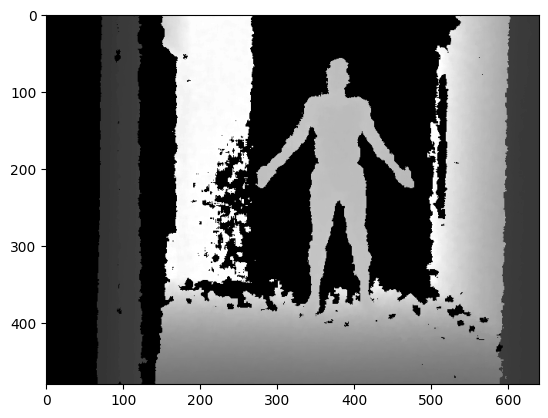

In [230]:
# Name
name = 'data/data.png'

# Image open
depth = cv2.imread(name, cv2.IMREAD_ANYDEPTH)
plt.imshow(depth, cmap='gray')

# Meta data load
with builtins.open('data/data.json') as f: ###
    meta = json.load(f)

# Constant extraction
k = meta.get('k') ###

skeleton_points = {}

for joint, coord in meta.items():
    if joint != 'k':
        skeleton_points[joint] = coord

print(k)
pprint(meta)

#### 2) Zobrazte skeleton
Využijte metadata skeletonu a **zobrazte body skeletonu** na snímku hloubkové mapy. Zobrazte také **spoje bodů skeletonu** podle obrázku výše. Bude se hodit funkce, která je schopna vrátit **dvojice klíčů** ze slovníku `meta` pro body skeletonu, které jsou vedle sebe.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [231]:
def skeleton_tuples(num=19):
    joints = list()
    joints.append(['head', 'shoulder_center'])

    joints.append(['shoulder_center', 'shoulder_left'])
    joints.append(['shoulder_left', 'elbow_left'])
    joints.append(['elbow_left', 'wrist_left'])
    joints.append(['wrist_left', 'hand_left'])

    joints.append(['shoulder_center', 'shoulder_right'])
    joints.append(['shoulder_right', 'elbow_right'])
    joints.append(['elbow_right', 'wrist_right'])
    joints.append(['wrist_right', 'hand_right'])

    joints.append(['shoulder_center', 'spine'])
    joints.append(['spine', 'hip_center'])
    
    joints.append(['hip_center', 'hip_left'])
    joints.append(['hip_left', 'knee_left'])
    joints.append(['knee_left', 'ankle_left'])
    joints.append(['ankle_left', 'foot_left'])

    joints.append(['hip_center', 'hip_right'])
    joints.append(['hip_right', 'knee_right'])
    joints.append(['knee_right', 'ankle_right'])
    joints.append(['ankle_right', 'foot_right'])
    
    return joints[0:num]

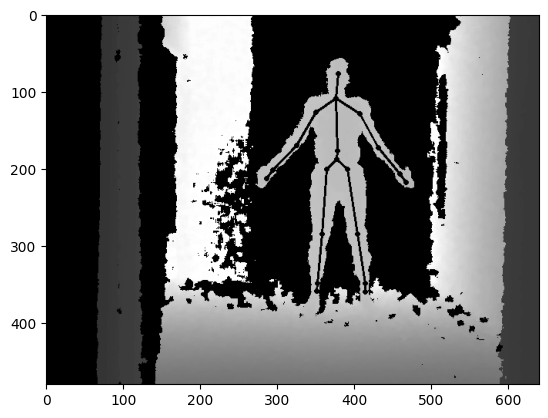

In [232]:
depth_draw = depth.copy()

# Draw all joints as circles
for joint, coord in skeleton_points.items():
    cv2.circle(depth_draw, coord, 2, (0,255,0), 2)

# Draw all lines
for joint_pair in skeleton_tuples():
    p1 = skeleton_points[joint_pair[0]]
    p2 = skeleton_points[joint_pair[1]]

    cv2.line(depth_draw, p1, p2, (0,255,0), 2)

plt.imshow(depth_draw, cmap='gray')

#### 3) Změřte výšku osoby `f1`
S pomocí bodů skeletonu změřte výšku osoby. Vzdálenost mezi bodem `head` a vrškem hlavy aproximujte jako 1/14 změřené výšky [2]. Měřte výšku osoby v cm! Hodnotu výšky uložte do proměnné `f1`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [233]:
f1 = 0

points = ['head', 'shoulder_center', 'spine', 'hip_center', 'hip_left', 'knee_left', 'ankle_left', 'foot_left']

for i in range(len(points) - 1):
    p1 = skeleton_points[points[i]]
    p2 = skeleton_points[points[i+1]]
    f1 += distance_cm(p1,p2,k)

# Approx of top head
f1 += f1/14

print(f'Výška osoby je {f1:.2f} cm.')

Výška osoby je 167.14 cm.


#### 4) Segmentujte osobu z obrazu
Z hloubkové mapy segmentujte osobu. Můžete využít znalosti, že měřený subjekt dle metodiky měření stál **296 cm** od senzoru. Tloušťku osoby zvolte maximálně **50 cm**. Jako výsledek si uložte **konturu osoby**, protože se pak bude hodit dále.

Můžete si pomoci **ručním oříznutím** obrázku, avšak nezapomeňte pak **přepočítat souřadnice** bodů skeletonu! 

<div style="color: blue; text-align: right">[ 1,5 bodu ]</div>

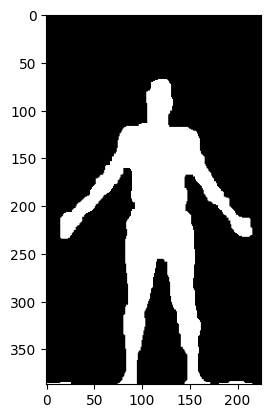

In [247]:
image = depth.copy()

# Don't forget to recount joints while cropping!
image = crop(image, 270,0,495,387)
meta_new = recount_joints(skeleton_points, (260,-8)) #

#plot_images(image)

# Segmentation
min_depth = 296 - 11
max_depth = 296 + 16

mask = cv2.inRange(image, min_depth*10, max_depth*10)

#plot_images(mask)

kernel = np.ones((4, 4), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

kernel2 = np.ones((2, 2), np.uint8)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel2, iterations=6)

mask_closed = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(mask_closed, cmap='gray')

# Gets one final contour in form of np.ndarray
_, _, cnt = find_contours(mask_closed, 100, 1000000)
contour_biggest = max(cnt, key=cv2.contourArea)

#### 5) Změřte další potřebné rozměry délku stehna `f2` a délku nadloktí `f4`
Změřte další rozměry potřebné k zisku odhadu hmotnosti člověka. Potřebné rozměry jsou zobrazené v [tabulce](#tab) na následujícícm obrázku. Rozměry uložte do proměnných `f2` a `f4`.

![](images/body_measurements.png)

<div style="color: blue; text-align: right">[ 0.75 bodu ]</div>

In [235]:
f2 = distance_cm(meta_new['hip_left'], meta_new['knee_left'],k)
f4 = distance_cm(meta_new['shoulder_left'], meta_new['elbow_left'],k)

print(f2)
print(f4)

45.549800000000005
26.85822861792639


#### 6) Nalezněte body kontury pro další měření
Najděte polohy bodů pro měření šířky kontury osoby p_3, p_5, p_7 a p_6. 
- Bod pro měření **lýtka** leží ve 2/3 délky mezi body skeletonu `knee` a `ankle`.
- Bod pro měření **paže** leží ve 2/3 délky mezi body skeletonu `shoulder` a `elbow`.
- Bod pro měření **stehna** leží ve 4/5 délky mezi body skeletonu `hip`a `knee`.
- Bod pro měření **pasu** leží v bodě skeletonu `hip_center`.

Dále nalezněte vždy 2 body kontury, které leží na normále (= přímce kolmé) k přímce spojující výše zmíněné body skeletonu a změřte vzdálenosti mezi nimi `d3`, `d5` a `d7`.

Pro vzdálenost `d6` se využije přímky spojující bod skeletonu `shoulder_center` s bodem `hip_center`.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [236]:
p_3 = point_in_distance(tuple(meta_new['knee_left']), tuple(meta_new['ankle_left']), 2/3)
p_5 = point_in_distance(tuple(meta_new['shoulder_left']), tuple(meta_new['elbow_left']), 2/3)
p_7 = point_in_distance(tuple(meta_new['hip_left']), tuple(meta_new['knee_left']), 4/5)
p_6 = meta_new['hip_center']

points = [p_3, p_5, p_7, p_6]
points = [(int(x), int(y)) for x, y in points]

10.237973024773996 7.912173381517875 13.567397944720279 30.00928


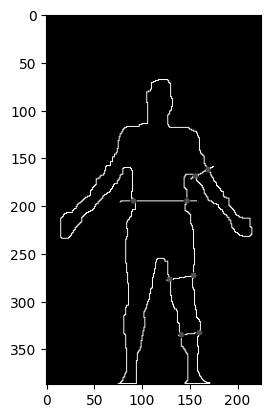

In [237]:
measured_joint_pairs = [
    [ tuple(meta_new['knee_left']), tuple(meta_new['ankle_left']) ],
    [ tuple(meta_new['shoulder_left']), tuple(meta_new['elbow_left']) ],
    [ tuple(meta_new['hip_left']), tuple(meta_new['knee_left']) ],
    [ tuple(meta_new['shoulder_center']), tuple(meta_new['hip_center']) ]
]

d3, d5, d7, d6 = measure_distances_using_impro(image, [contour_biggest], points, measured_joint_pairs)
print(d3, d5, d7, d6)

#### 7) Spočítejte další potřebné rozměry obvod lýtka `f3`, obvod paže `f5` a obvod stehna `f7`
Předpokládejme, že lýtko, paže i stehno lze aproximovat geometrickým útvarem válce. Z obrazu jsme získali vzdálenosti kontury osoby v potřebných bodech. Potom výpočet obvodů `f3`, `f5` a `f7` lze získat dle následujícího vzorce.

$f_i = \pi \cdot d_i$, pro $i \in \{3, 5, 7\}$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [238]:
f3 = math.pi * d3
f5 = math.pi * d5
f7 = math.pi * d7

print(f3)
print(f5)
print(f7)

32.16354084228046
24.856825769305267
42.62323771146249


#### 8) Spočítejte další potřebný rozměr obvod pasu `f6`
Předpokládejte, že pas nelze úplně aproximovat válcem. Tento rozměr vezmeme jako jeden hraniční. Jako druhý hraniční rozměr vezmeme dvojnásobek rozměru `d6`. Jejich průmerem pak vypočteme obvod pasu podle vzorce:

$$
f_6 = \frac{\pi \cdot d_6 + 2 \cdot d_6}{2}
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [239]:
f6 = ( (math.pi * d6) + (2 * d6) ) / 2

print(f6)

77.14774679375955


#### 9) Spočítejte odhad hmotnosti
Dle [1] lze spočítat odhad hmotnosti člověka v kg podle následujícího vzorce.

$$
m = -122,27 + 0,48 \cdot f_1 - 0,17 \cdot f_2 + 0,52 \cdot f_3 + 0,16 \cdot f_4 + 0,77 \cdot f_5 + 0,49 \cdot f6 + 0,58 \cdot f_7
$$

<div style="color: blue; text-align: right">[ 0.25 bodu ]</div>

In [240]:
m = -122.27 + 0.48*f1 - 0.17*f2 + 0.52*f3 + 0.16*f4 + 0.77*f5 + 0.49*f6 + 0.58*f7

print(f'Hmotnost osoby je {m:.2f} kg.')

Hmotnost osoby je 52.90 kg.


#### 10) Spočtěte BMI
Ze standardního vztahu vypočtěte BMI jako poměr hmotnosti $m$ v kg a výšky $h$ v m člověka.

$$
BMI = \frac{m}{h^2}
$$

<div style="color: blue; text-align: right">[ 0.5 bodu ]</div>

In [241]:
h = f1 / 100

BMI = m / (h**2)

print(f'Výsledné BMI je {BMI:.2f} kg/m2.')

Výsledné BMI je 18.94 kg/m2.


---

#### 11) Prémium #1
Nabízím 1 prémiový bod za vysvětlení principu funkčnosti [speciální funkce](#premium) formou volného textu, ze kterého bude jasné její pochopení. 

#### 12) Prémium #2
Nabízím 1 prémiový bod za ekvivalentní funkci ke [speciální funkci](#premium), která bude založena na geometrickém zjištění protínajících se bodů kontury s body normály. Hodně je toho vyřešeno již v [pomocných funkcích](help_functions.ipynb).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dd8fd64a-73b5-45e5-8bd2-9e8e3887d224' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Ekvivalentní funkce ke speciální funkci:

In [245]:
def measure_distances_geometric(image, contour, specified_points, measured_joints_pairs):
    dxs = [12, 12, 15, 40]
    dists = []
    for i, point in enumerate(specified_points):
        p1 = measured_joints_pairs[i][0]
        p2 = measured_joints_pairs[i][1]

        # Získání parametrů úsečky mezi body p1 a p2
        k_line, q_line = kq_of_line_segment(p1, p2)
        
        # Získání parametrů normály
        k_normal, q_normal = normal_kq_in_point(point, k_line, q_line)

        # Výpočet počátečních a koncových bodů normály
        start, end = normal_line_start_end_points(point, k_line, q_line, dxs[i])

        intersection_points = []

        for j in range(len(contour[0]) - 1):
            c1 = tuple(contour[0][j][0])
            c2 = tuple(contour[0][j+1][0])
            
            # Výpočet průsečíku mezi normálovou úsečkou a segmentem kontury
            if c2[0] - c1[0] == 0:
                x_contour = c1[0]
                y_intersect = k_normal * x_contour + q_normal
                x_intersect = x_contour
            else:
                k_contour = (c2[1] - c1[1]) / (c2[0] - c1[0])
                q_contour = c1[1] - k_contour * c1[0]

                x_intersect = (q_contour - q_normal) / (k_normal - k_contour)
                y_intersect = k_normal * x_intersect + q_normal

            # Kontrola, zda průsečík leží na obou úsecích
            if is_point_on_segment((x_intersect, y_intersect), c1, c2) and is_point_on_segment((x_intersect, y_intersect), start, end):
                intersection_points.append((x_intersect, y_intersect))

        if len(intersection_points) >= 2:
            # Výpočet vzdálenosti mezi prvními dvěma průsečíky
            p_int1 = intersection_points[0]
            p_int2 = intersection_points[1]
            dist_cm = distance_cm(p_int1, p_int2, k)

            if dist_cm > 2 * k:
                dists.append(dist_cm)

    assert len(dists) == 4, 'You don\'t have enough points to measure distances.'

    return dists[0], dists[1], dists[2], dists[3]


Jsou zde jen drobné odchylky od vypočtených hodnot původní funkce

In [246]:
d3, d5, d7, d6 = measure_distances_geometric(image, [contour_biggest], points, measured_joint_pairs)
print(d3, d5, d7, d6)

10.30525909825605 8.007199173526185 13.556488095238098 28.97161572860582
